In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import timm

from tqdm import tqdm
from torch import nn
from torch.nn import functional as F
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import Adam


# ConvLSTM Cell
![](https://miro.medium.com/v2/resize:fit:828/format:webp/1*1D6sthiJD20UyC_jYktjZQ.png)

In [3]:
# thank for this source code: https://github.com/ndrplz/ConvLSTM_pytorch/blob/master/convlstm.py#L178
class ConvLSTMCell(nn.Module):

    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.

        Parameters
        ----------
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))

# ConvLSTM

In [4]:
# thank for this source code: https://github.com/ndrplz/ConvLSTM_pytorch/blob/master/convlstm.py#L178
# and modify

class ConvLSTM(nn.Module):

    """
    Parameters:
        input_dim: Number of channels in input
        hidden_dim: Number of hidden channels
        kernel_size: Size of kernel in convolutions
        num_layers: Number of LSTM layers stacked on each other
        batch_first: Whether or not dimension 0 is the batch or not
        bias: Bias or no bias in Convolution
    """

    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=False, bias=True):
        super(ConvLSTM, self).__init__()

        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)
        
        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """
        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (batch, channels, time, height, width)
        hidden_state: todo
            None. todo implement stateful

        Returns
        -------
        layer_output_list, h_n (num_layers, batch, hidden_dim, height, width), cn
        """
        if not self.batch_first:
            # 
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)
        b, _, _, h, w = input_tensor.size()

        # Implement stateful ConvLSTM
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            # Since the init is done in forward. Can send image size here
            hidden_state = self._init_hidden(batch_size=b, image_size=(h, w))

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(2)
        cur_layer_input = input_tensor

        h_n = []
        c_n = []
        
        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, :,t, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim = 2)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            h_n.append(h)
            c_n.append(c)
            
        return torch.stack(layer_output_list)[-1]
        return layer_output_list, (torch.stack(h_n), torch.stack(c_n))

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param

# Custom model

In [6]:
class NextFramePredictionModel(nn.Module):
    def __init__(self, in_channels, hidden_dim, kernel_size, num_convlstm_layers = 1, num_lstmcell_layers = 1, batch_first = True):
        super().__init__()
        
        self.conv_lstm = nn.Sequential()
        
        self.conv_lstm.add_module(
            'convlstm0',ConvLSTM(in_channels, hidden_dim, kernel_size, num_lstmcell_layers, batch_first)
        )
        self.conv_lstm.add_module(
            'bn0', nn.BatchNorm3d(hidden_dim)
        )
        self.conv_lstm.add_module(
            f'bn{0}', nn.ReLU()
        )
        
        for i in range(1, num_convlstm_layers):
            self.conv_lstm.add_module(
            f'convlstm{i}',ConvLSTM(hidden_dim, hidden_dim, kernel_size, num_lstmcell_layers, batch_first)
        )
            self.conv_lstm.add_module(
            f'bn{i}', nn.BatchNorm3d(hidden_dim)
        )
        
            self.conv_lstm.add_module(
            f'bn{i}', nn.ReLU()
        )
            
        self.out = nn.Conv3d(in_channels = hidden_dim, out_channels = in_channels, kernel_size = 3, padding = 1, stride = 1)
        
    def forward(self, x):
        '''x: batch, channels,time, height, width'''
        x_shape = x.shape

        x = self.conv_lstm(x)
        
        x = self.out(x)
        
#         x = F.interpolate(x, x_shape[-2:], mode = 'bilinear')
            
        return F.sigmoid(x)
        

In [7]:
model = NextFramePredictionModel(1, 64, (3,3), 5, batch_first = True)
x = torch.rand(2,1,5,64,64)
y = model(x)
y.shape


torch.Size([2, 1, 5, 64, 64])

# Split dataloader

In [8]:
def split_dataloader(train_data, validation_split = 0.2):
    # Chia DataLoader thành phần train và test
    train_ratio = 1 - validation_split  # Tỷ lệ phần train (80%)
    train_size = int(train_ratio * len(train_data.dataset))  # Số lượng mẫu dùng cho train

    indices = list(range(len(train_data.dataset)))  # Danh sách các chỉ số của dataset
    train_indices = indices[:train_size]  # Chỉ số của mẫu dùng cho train
    val_indices = indices[train_size:]  # Chỉ số của mẫu dùng cho test

    # lấy dữ liệu từ dataloader
    dataset = train_data.dataset
    batch_size = train_data.batch_size
    num_workers = train_data.num_workers
    
    # Tạo ra các SubsetRandomSampler để chọn một phần dữ liệu cho train và test
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    # Tạo DataLoader mới từ SubsetRandomSampler
    train_data = DataLoader(dataset, batch_size = batch_size, sampler = train_sampler, num_workers = num_workers, drop_last = True)
    val_data = DataLoader(dataset, batch_size = batch_size, sampler = val_sampler, num_workers = num_workers, drop_last = True)
    

    return train_data, val_data


# Evaluate function

In [9]:
def evaluate(model, val_data, loss_fn, weights = None, device = 'cpu', verbose = 0):
    # set device
    if (device == 'gpu' or device == 'cuda') and torch.cuda.is_available():
        device = torch.device('cuda')
    elif isinstance(device, torch.device): 
        device = device
    else: 
        device = torch.device('cpu')
    
    model = model.to(device)

    if weights:
        model.load_state_dict(torch.load(weights))
        print('Weights loaded successfully from path:', weights)
        print('====================================================')
    
    with torch.no_grad():
        model.eval()
        val_correct = 0
        running_loss = 0.
        if verbose == 1:
            val_data = tqdm(val_data, desc = 'Evaluate: ', ncols = 100)
        for data_batch, label_batch in val_data:
            data_batch, label_batch = data_batch.to(device), label_batch.to(device)

            # tính toán đầu ra cho bộ valid
            output_batch = model(data_batch)

            loss = loss_fn(output_batch, label_batch.float())
            running_loss += loss.item()

            # dự đoán đầu ra với softmax
            predicted_labels = torch.round(output_batch.data)
            val_correct += (label_batch == predicted_labels).sum().item()/torch.prod(torch.tensor(label_batch.shape))
            
        val_loss = running_loss/len(val_data)
        val_acc = val_correct/len(val_data)
        return val_loss, val_acc


# Train function

In [10]:
def train(model, train_data, loss_fn, optimizer, epochs, weights = None, save_last_weights_path = None,
          save_best_weights_path = None, freeze = False, steps_per_epoch = None,
          device = 'cpu', validation_data = None, validation_split = None, scheduler = None):
    
    # đặt validation_data and validation_split không đồng thời khác None
    assert not(validation_data is not None and validation_split is not None)
    
    # nếu truyền vào model trọng số có sẵn, thì nó sẽ lưu trọng số lại 
    if weights:
        model.load_state_dict(torch.load(weights))
        print('Weights loaded successfully from path:', weights)
        print('====================================================')
    
    # set device
    if (device == 'gpu' or device == 'cuda') and torch.cuda.is_available():
        device = torch.device('cuda')
    elif isinstance(device, torch.device): 
        device = device
    else: 
        device = torch.device('cpu')
        
    # chia dữ liệu thành 2 tập train và val    
    if validation_data is not None:
        val_data = validation_data
    elif validation_split is not None: 
        train_data, val_data = split_dataloader(train_data, validation_split)
    else: 
        val_data = None
        
    # save best model
    if save_best_weights_path: 
        if val_data is None:
            train_data, val_data = split_dataloader(train_data, 0.2)
        best_loss, _ = evaluate(model, val_data, device = device, loss_fn = loss_fn)  
        
    # đặt số lần update weights trong 1 epoch
    if steps_per_epoch is None: 
        steps_per_epoch = len(train_data)

    num_steps = len(train_data)
    iterator = iter(train_data)
    count_steps = 1    
    
    ## History
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_acc': [],
        'val_loss': []
    }
        
    # add model to device
    model = model.to(device)
    
    ############################### Train and Val ##########################################
    for epoch in range(1, epochs + 1):
        # tính tổng giá trị hàm mất mát cho mỗi epoch
        running_loss = 0.
        train_correct = 0
        
        # đặt model ở chế độ huấn luyện 
        model.train()
        
        for step in tqdm(range(steps_per_epoch), desc = f'epoch: {epoch}/{epochs}: ', ncols = 100): 
            img_batch, label_batch = next(iterator)
            img_batch, label_batch = img_batch.to(device), label_batch.to(device)
            
            # Xóa các gradient
            optimizer.zero_grad()
            
            # tính toán đầu ra
            output_batch = model(img_batch)
            
            # tính loss
            loss = loss_fn(output_batch, label_batch.float())
            
            # lan truyền ngược
            loss.backward()
            
            # cập nhật trọng số cho mạng
            optimizer.step()
            
            # accuracy with pixel-wise
            predicted_labels = torch.round(output_batch.data)
            train_correct += (label_batch == predicted_labels).sum().item()/torch.prod(torch.tensor(label_batch.shape))
                
            # Cập nhật tổng hàm mất mát
            running_loss += loss.item()
                
            if count_steps == num_steps:
                count_steps = 0
                iterator = iter(train_data)
            count_steps += 1
            
        train_loss = running_loss / steps_per_epoch
        train_accuracy = train_correct / steps_per_epoch
        
        # reduce lr
        if scheduler:
            scheduler.step(train_loss)
        
        history['train_loss'].append(float(train_loss))
        history['train_acc'].append(float(train_accuracy))
        
        if val_data is not None: 
            val_loss, val_acc = evaluate(model, val_data, device = device, loss_fn = loss_fn)
            print(f'epoch: {epoch}, train_accuracy: {train_accuracy: .2f}, loss: {train_loss: .3f}, val_accuracy: {val_acc: .2f}, val_loss: {val_loss:.3f}')

            if save_best_weights_path:
                if val_loss < best_loss:
                    best_loss = val_loss
                    torch.save(model.state_dict(), save_best_weights_path)
                    print(f'Saved successfully best weights to:', save_best_weights_path)
            history['val_loss'].append(float(val_loss))
            history['val_acc'].append(float(val_acc))
        else:
            print(f'epoch: {epoch}, train_accuracy: {train_accuracy: .2f}, loss: {train_loss: .3f}')
    if save_last_weights_path:  
        torch.save(model.state_dict(), save_last_weights_path)
        print(f'Saved successfully last weights to:', save_last_weights_path)
    return model, history


# Parameter

In [11]:
data_path = '/kaggle/input/moving-mnist/mnist_test_seq.npy'
last_weights = 'ConvLSTM.pt'

in_channels = 1
hidden_dim = 64
batch_first = True
batch_size = 12
kernel_size = 3
num_workers = os.cpu_count()
device = 'cuda' if torch.cuda.is_available() else 'cpu'


# Load data

In [12]:
# Load Data as Numpy Array
# num sample, length sequence, height, width
MovingMNIST = np.load(data_path).transpose(1, 0, 2, 3)

# Shuffle Data
np.random.shuffle(MovingMNIST)

# Train, Test, Validation splits
train_data = MovingMNIST[:8000]         
val_data = MovingMNIST[8000:9000]       
test_data = MovingMNIST[9000:10000]     

def collate(batch):

    # Add channel dim, scale pixels between 0 and 1, send to GPU
    batch = torch.from_numpy(np.array(batch)).unsqueeze(1)     
    batch = batch / 255.0                        

    # Randomly pick 10 frames as input, 11th frame is target
    return batch[:,:,:19], batch[:,:,1:20]     

# Training Data Loader
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, collate_fn=collate, drop_last = True, num_workers = num_workers)

# Validation Data Loader
val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size, collate_fn=collate, num_workers = num_workers)

# Create model and optim, loss function

In [13]:
model = NextFramePredictionModel(
    in_channels = in_channels, 
    hidden_dim = hidden_dim, 
    kernel_size = kernel_size, 
    num_convlstm_layers = 3,
    num_lstmcell_layers = 2,
    batch_first = True
)

optimizer = Adam(model.parameters(), lr = 1e-4)
loss_fn = nn.BCELoss()
scheduler = ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.25, patience = 3, verbose = 1)

In [14]:
total_params = sum(p.numel() for p in model.parameters())
print('Total parametes in model:', total_params)

Total parametes in model: 1627585


# Train model

In [22]:
model, history = train(model, train_loader, loss_fn, optimizer, weights = None, epochs = 50,
              save_last_weights_path = last_weights, save_best_weights_path = None,
              device = device, validation_data = val_loader, steps_per_epoch = 100, scheduler = scheduler)


epoch: 1/50: 100%|████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


epoch: 1, train_accuracy:  0.82, loss:  0.313, val_accuracy:  0.93, val_loss: 0.202


epoch: 2/50: 100%|████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


epoch: 2, train_accuracy:  0.93, loss:  0.199, val_accuracy:  0.93, val_loss: 0.200


epoch: 3/50: 100%|████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


epoch: 3, train_accuracy:  0.93, loss:  0.196, val_accuracy:  0.93, val_loss: 0.195


epoch: 4/50: 100%|████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


epoch: 4, train_accuracy:  0.93, loss:  0.189, val_accuracy:  0.93, val_loss: 0.185


epoch: 5/50: 100%|████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


epoch: 5, train_accuracy:  0.93, loss:  0.184, val_accuracy:  0.93, val_loss: 0.179


epoch: 6/50: 100%|████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


epoch: 6, train_accuracy:  0.93, loss:  0.173, val_accuracy:  0.93, val_loss: 0.161


epoch: 7/50: 100%|████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


epoch: 7, train_accuracy:  0.93, loss:  0.133, val_accuracy:  0.93, val_loss: 0.111


epoch: 8/50: 100%|████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


epoch: 8, train_accuracy:  0.92, loss:  0.102, val_accuracy:  0.92, val_loss: 0.097


epoch: 9/50: 100%|████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


epoch: 9, train_accuracy:  0.92, loss:  0.095, val_accuracy:  0.92, val_loss: 0.094


epoch: 10/50: 100%|███████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


epoch: 10, train_accuracy:  0.92, loss:  0.093, val_accuracy:  0.92, val_loss: 0.091


epoch: 11/50: 100%|███████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


epoch: 11, train_accuracy:  0.92, loss:  0.090, val_accuracy:  0.92, val_loss: 0.091


epoch: 12/50: 100%|███████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


epoch: 12, train_accuracy:  0.92, loss:  0.089, val_accuracy:  0.92, val_loss: 0.088


epoch: 13/50: 100%|███████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


epoch: 13, train_accuracy:  0.92, loss:  0.087, val_accuracy:  0.92, val_loss: 0.087


epoch: 14/50: 100%|███████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


epoch: 14, train_accuracy:  0.92, loss:  0.087, val_accuracy:  0.92, val_loss: 0.086


epoch: 15/50: 100%|███████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


epoch: 15, train_accuracy:  0.92, loss:  0.086, val_accuracy:  0.92, val_loss: 0.086


epoch: 16/50: 100%|███████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


epoch: 16, train_accuracy:  0.92, loss:  0.085, val_accuracy:  0.92, val_loss: 0.084


epoch: 17/50: 100%|███████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


epoch: 17, train_accuracy:  0.92, loss:  0.084, val_accuracy:  0.92, val_loss: 0.084


epoch: 18/50: 100%|███████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


epoch: 18, train_accuracy:  0.92, loss:  0.084, val_accuracy:  0.92, val_loss: 0.084


epoch: 19/50: 100%|███████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


epoch: 19, train_accuracy:  0.92, loss:  0.083, val_accuracy:  0.92, val_loss: 0.083


epoch: 20/50: 100%|███████████████████████████████████████████████| 100/100 [01:35<00:00,  1.04it/s]


epoch: 20, train_accuracy:  0.92, loss:  0.082, val_accuracy:  0.92, val_loss: 0.082


epoch: 21/50: 100%|███████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


epoch: 21, train_accuracy:  0.92, loss:  0.081, val_accuracy:  0.92, val_loss: 0.082


epoch: 22/50: 100%|███████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


epoch: 22, train_accuracy:  0.92, loss:  0.081, val_accuracy:  0.92, val_loss: 0.081


epoch: 23/50: 100%|███████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


epoch: 23, train_accuracy:  0.92, loss:  0.081, val_accuracy:  0.92, val_loss: 0.081


epoch: 24/50: 100%|███████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


epoch: 24, train_accuracy:  0.92, loss:  0.080, val_accuracy:  0.92, val_loss: 0.080


epoch: 25/50: 100%|███████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


epoch: 25, train_accuracy:  0.92, loss:  0.079, val_accuracy:  0.92, val_loss: 0.080


epoch: 26/50: 100%|███████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


epoch: 26, train_accuracy:  0.92, loss:  0.079, val_accuracy:  0.92, val_loss: 0.079


epoch: 27/50: 100%|███████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


epoch: 27, train_accuracy:  0.92, loss:  0.079, val_accuracy:  0.92, val_loss: 0.079


epoch: 28/50: 100%|███████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


epoch: 28, train_accuracy:  0.92, loss:  0.078, val_accuracy:  0.92, val_loss: 0.078


epoch: 29/50: 100%|███████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


epoch: 29, train_accuracy:  0.92, loss:  0.079, val_accuracy:  0.92, val_loss: 0.078


epoch: 30/50: 100%|███████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


epoch: 30, train_accuracy:  0.92, loss:  0.078, val_accuracy:  0.92, val_loss: 0.078


epoch: 31/50: 100%|███████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


epoch: 31, train_accuracy:  0.92, loss:  0.078, val_accuracy:  0.92, val_loss: 0.079


epoch: 32/50: 100%|███████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


epoch: 32, train_accuracy:  0.92, loss:  0.077, val_accuracy:  0.92, val_loss: 0.077


epoch: 33/50: 100%|███████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


epoch: 33, train_accuracy:  0.92, loss:  0.077, val_accuracy:  0.92, val_loss: 0.077


epoch: 34/50: 100%|███████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


epoch: 34, train_accuracy:  0.92, loss:  0.076, val_accuracy:  0.92, val_loss: 0.077


epoch: 35/50: 100%|███████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


epoch: 35, train_accuracy:  0.92, loss:  0.077, val_accuracy:  0.92, val_loss: 0.076


epoch: 36/50: 100%|███████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


epoch: 36, train_accuracy:  0.92, loss:  0.077, val_accuracy:  0.92, val_loss: 0.077


epoch: 37/50: 100%|███████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


epoch: 37, train_accuracy:  0.92, loss:  0.077, val_accuracy:  0.92, val_loss: 0.076


epoch: 38/50: 100%|███████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]

Epoch 00038: reducing learning rate of group 0 to 2.5000e-05.


epoch: 38, train_accuracy:  0.92, loss:  0.076, val_accuracy:  0.92, val_loss: 0.075


epoch: 39/50: 100%|███████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


epoch: 39, train_accuracy:  0.92, loss:  0.076, val_accuracy:  0.92, val_loss: 0.076


epoch: 40/50: 100%|███████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


epoch: 40, train_accuracy:  0.92, loss:  0.075, val_accuracy:  0.92, val_loss: 0.075


epoch: 41/50: 100%|███████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


epoch: 41, train_accuracy:  0.92, loss:  0.075, val_accuracy:  0.92, val_loss: 0.075


epoch: 42/50: 100%|███████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


epoch: 42, train_accuracy:  0.92, loss:  0.076, val_accuracy:  0.92, val_loss: 0.075


epoch: 43/50: 100%|███████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


epoch: 43, train_accuracy:  0.92, loss:  0.076, val_accuracy:  0.92, val_loss: 0.075


epoch: 44/50: 100%|███████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


epoch: 44, train_accuracy:  0.92, loss:  0.076, val_accuracy:  0.92, val_loss: 0.075


epoch: 45/50: 100%|███████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


epoch: 45, train_accuracy:  0.92, loss:  0.075, val_accuracy:  0.92, val_loss: 0.076


epoch: 46/50: 100%|███████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


epoch: 46, train_accuracy:  0.92, loss:  0.075, val_accuracy:  0.92, val_loss: 0.076


epoch: 47/50: 100%|███████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


epoch: 47, train_accuracy:  0.92, loss:  0.075, val_accuracy:  0.92, val_loss: 0.075


epoch: 48/50: 100%|███████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


epoch: 48, train_accuracy:  0.92, loss:  0.075, val_accuracy:  0.92, val_loss: 0.075


epoch: 49/50: 100%|███████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


epoch: 49, train_accuracy:  0.92, loss:  0.076, val_accuracy:  0.92, val_loss: 0.076


epoch: 50/50: 100%|███████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


epoch: 50, train_accuracy:  0.92, loss:  0.075, val_accuracy:  0.92, val_loss: 0.076
Saved successfully last weights to: ConvLSTM.pt


# Visualize history

In [38]:
def visualize_history(history, metrics = ['acc', 'loss']):   
    
    if 'acc' in metrics:
        plt.figure(figsize = (10,6))
        plt.subplot(121)
        plt.plot(range(1, len(history['train_acc']) + 1), history['train_acc'], label = 'train_acc', c = 'r')
        plt.plot(range(1, len(history['val_acc']) + 1), history['val_acc'], label = 'val_acc', c = 'g')
        plt.title('Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

    if 'loss' in metrics:
        plt.subplot(122)
        plt.plot(range(1, len(history['train_loss']) + 1), history['train_loss'], label = 'train_loss', c = 'r')
        plt.plot(range(1, len(history['val_loss']) + 1), history['val_loss'], label = 'val_loss', c = 'g')
        plt.title('Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

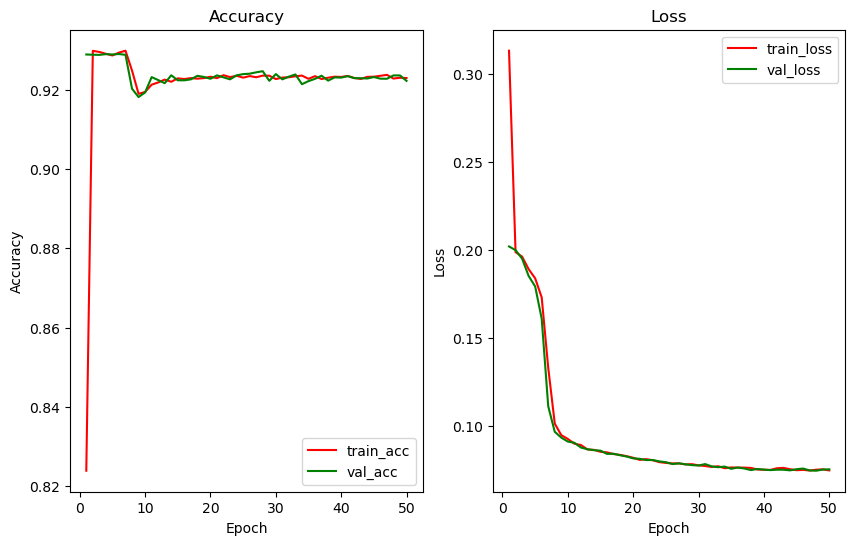

In [27]:
visualize_history(history)

# Evaluate model

In [25]:
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, collate_fn=collate, num_workers = num_workers)
test_loss, test_acc = evaluate(model, weights = last_weights, val_data = test_loader, loss_fn = loss_fn, device = device, verbose = 1)
print(f'Loss: {test_loss : .3f}, Acc: {test_acc: .3f}')


Weights loaded successfully from path: ConvLSTM.pt


Evaluate: 100%|█████████████████████████████████████████████████████| 63/63 [00:17<00:00,  3.63it/s]

Loss:  0.075, Acc:  0.923


# Prediction

In [69]:
class prediction():
    def __init__(self, model, weights = None, device = 'cpu', num_time = None, output_sequence = False):
        if isinstance(device, str):
            if (device == 'gpu' or device == 'cuda') and torch.cuda.is_available():
                device = 'cuda'
            else:
                device = 'cpu'
        if weights:
            model.load_state_dict(torch.load(weights, map_location=torch.device(device)))
            print('Weights loaded successfully from path:', weights)
            print('====================================================')

        self.device = torch.device(device)
        self.model = model.to(self.device)
        self.output_sequence = output_sequence
        self.num_time = num_time 

    def infer(self, x):
        assert len(x.shape) in [4,5]
        '''x: batch, channels, time, height, width or time, channels, height, width'''
        x_shape = x.shape

        if not torch.is_tensor(x):
            if isinstance(x, np.ndarray):
                x = torch.from_numpy(x)
            else:
                x = torch.tensor(x)
        ori_x = x.clone()
        if len(x_shape) == 4:
            x = x.unsqueeze(0)

        # x: batch, channels, time, height, width
        if self.num_time:
            if x.shape[3] > self.num_time:
                x = x[:, :,-self.num_time:]

        if torch.max(x).item() > 1:
            x  = x/255.
        x = x.to(self.device)

        # y: batch, channels, height, width
        y = self.model(x)

        if len(x_shape) == 4:
            y = y.squeeze(dim = 0)

        y = y.cpu()

        if self.output_sequence:
            # y: channels, time, height, width
            if len(x_shape) == 4:
                y = torch.concat([ori_x, y[:, -2:-1]], dim = 1)
            else:
                y = torch.concat([ori_x, y[:,:, -2:-1]], dim = 2)
        return y.detach().numpy()

Weights loaded successfully from path: ConvLSTM.pt
120


Text(0.5, 1.0, 'predict')

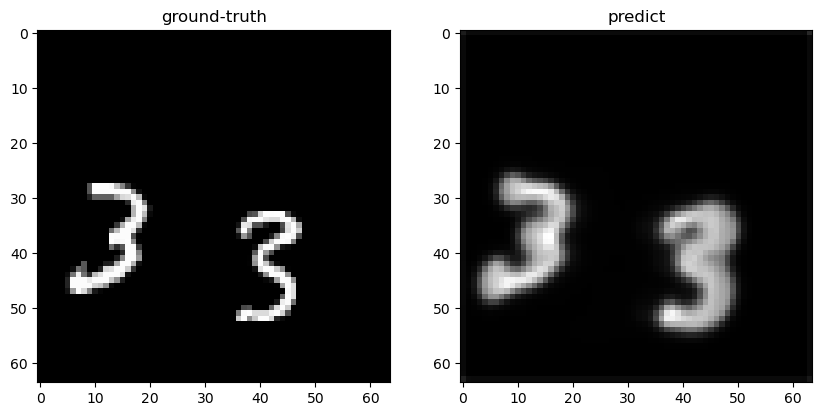

In [54]:
num_time = 19
predictor = prediction(model ,weights = last_weights, device = device, output_sequence = False, num_time = None)
idx = np.random.randint(0,200)
sample = test_data[idx]
print(idx)
# add channels for sample
x = np.expand_dims(sample, axis = 0)
y = predictor.infer(x)

plt.figure(figsize = (10,8))
plt.subplot(121)
plt.imshow(sample[num_time], 'gray')
plt.title('ground-truth')

plt.subplot(122)
plt.imshow((y[0, 19]), 'gray')
plt.title('predict')

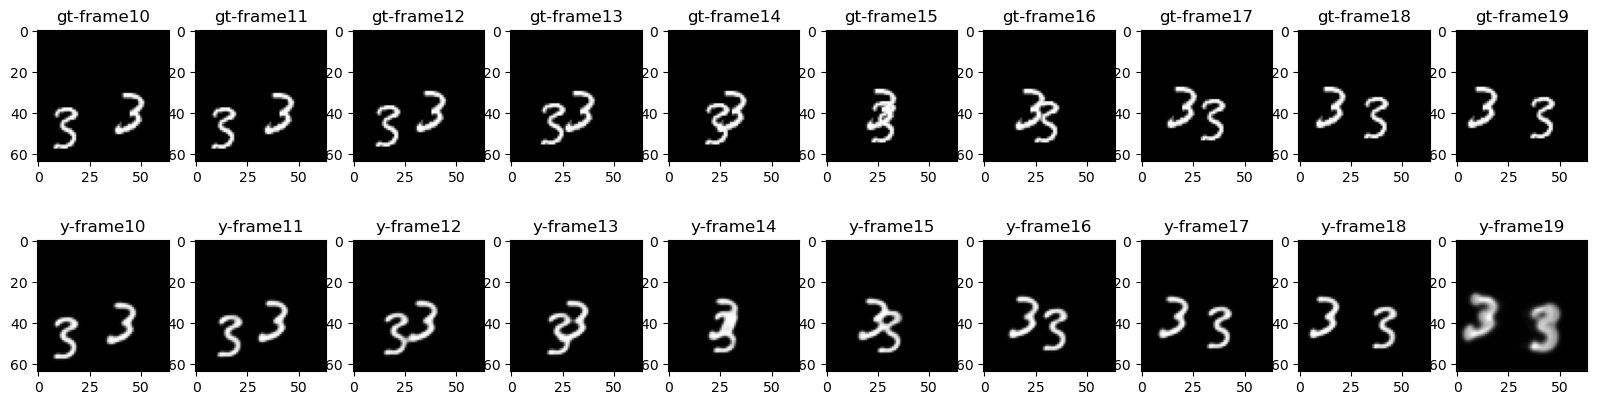

In [65]:
plt.figure(figsize = (20,5))
for i in range(1,11):
    plt.subplot(2,10,i)
    frame = i + 9
    # from frame 10
    plt.imshow(x[0, frame], 'gray')
    plt.title(f'gt-frame{frame}')
    
for i in range(11,21):
    plt.subplot(2,10,i)
    frame = i - 1
    # from frame 10
    plt.imshow(y[0, frame], 'gray')
    plt.title(f'y-frame{frame}')
    

In [70]:
predictor = prediction(model ,weights = last_weights, device = device, output_sequence = True, num_time = None)
num_frame_predict = 20
x = test_data[189]
# add channels for sample

x = np.expand_dims(x, axis = 0)

for i in range(num_frame_predict):
    x = predictor.infer(x)
x = x.squeeze(0)

Weights loaded successfully from path: ConvLSTM.pt


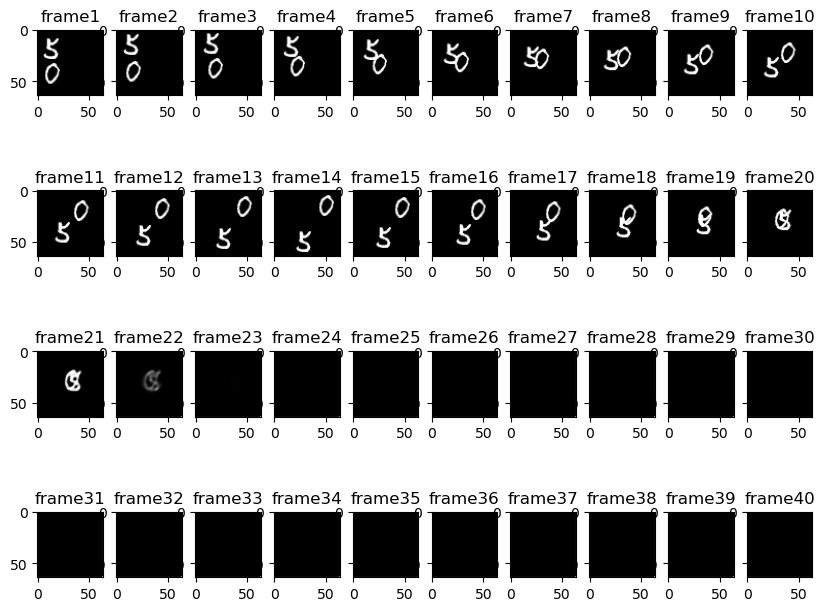

In [71]:
plt.figure(figsize = (10,8))
for i in range(1,41):
    plt.subplot(4,10,i)
    plt.imshow(x[i-1], 'gray')
    plt.title(f'frame{i}')
    

In [53]:
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox
import imageio
import io
with io.BytesIO() as gif:
    imageio.mimsave(gif, x.squeeze(0), "GIF", duration=200)    
    output_gif = gif.getvalue()

display(HBox([widgets.Image(value=output_gif)]))